<a href="https://colab.research.google.com/github/EEarth1270/houseprice-prediction/blob/randomforest/HousePriceRandomForesr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [188]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
from scipy.stats import iqr
from pandas.api.types import CategoricalDtype 


In [355]:
train_dataset = pd.read_csv('/content/drive/My Drive/Datasci/train.csv')

# Pre-processing

In [356]:
corrMatrix = train_dataset.corr()
print(corrMatrix)

                     Id  MSSubClass  LotFrontage  ...    MoSold    YrSold  SalePrice
Id             1.000000    0.011156    -0.010601  ...  0.021172  0.000712  -0.021917
MSSubClass     0.011156    1.000000    -0.386347  ... -0.013585 -0.021407  -0.084284
LotFrontage   -0.010601   -0.386347     1.000000  ...  0.011200  0.007450   0.351799
LotArea       -0.033226   -0.139781     0.426095  ...  0.001205 -0.014261   0.263843
OverallQual   -0.028365    0.032628     0.251646  ...  0.070815 -0.027347   0.790982
OverallCond    0.012609   -0.059316    -0.059213  ... -0.003511  0.043950  -0.077856
YearBuilt     -0.012713    0.027850     0.123349  ...  0.012398 -0.013618   0.522897
YearRemodAdd  -0.021998    0.040581     0.088866  ...  0.021490  0.035743   0.507101
MasVnrArea    -0.050298    0.022936     0.193458  ... -0.005965 -0.008201   0.477493
BsmtFinSF1    -0.005024   -0.069836     0.233633  ... -0.015727  0.014359   0.386420
BsmtFinSF2    -0.005968   -0.065649     0.049900  ... -0.015211  

In [357]:
print(train_dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [358]:
# a=pd.isna(train_dataset).sum() > 0
# text_file = open("/content/drive/My Drive/Datasci/out4.txt", "w")
# n = text_file.write(a.to_string())
# text_file.close()

In [359]:
train_dataset['LotFrontage'].fillna(0,inplace=True)

In [360]:
col = ['Id','MSSubClass','LotArea','LotFrontage','OverallQual','OverallCond','TotalBsmtSF','GrLivArea','GarageCars','GarageArea']
salePrice = train_dataset['SalePrice']

In [361]:
train_dataset= train_dataset[col]

Cleaning Data

Remove Outlier with IQR


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


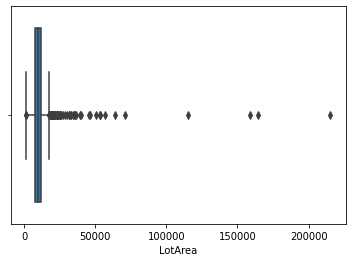

In [362]:
sns.boxplot(train_dataset['LotArea'])

In [363]:
iqr_lotArea = iqr(train_dataset['LotArea']) *1.5
Q75 = train_dataset['LotArea'].quantile(0.75) +iqr_lotArea
Q25 = train_dataset['LotArea'].quantile(0.25) -iqr_lotArea
print(iqr_lotArea)
print(Q25,Q75)

6072.0
1481.5 17673.5


In [364]:
# train_dataset = train_dataset[train_dataset['LotArea']>1481.5]
train_dataset = train_dataset[train_dataset['LotArea']<17673.5]

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


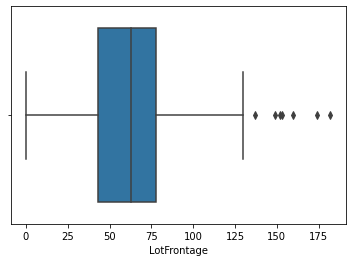

In [365]:
sns.boxplot(train_dataset['LotFrontage'])

In [366]:
iqr_lotFrontage = iqr(train_dataset['LotFrontage']) *1.5
Q75 = train_dataset['LotFrontage'].quantile(0.75)
Q25 = train_dataset['LotFrontage'].quantile(0.25)
print(iqr_lotFrontage)
print(Q25,Q75)

52.5
43.0 78.0


In [367]:
train_dataset = train_dataset[train_dataset['LotFrontage']<130.5]
# train_dataset = train_dataset[train_dataset['LotFrontage']>9]

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


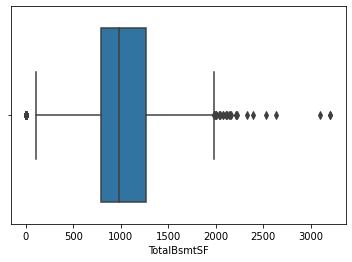

In [368]:
sns.boxplot(train_dataset['TotalBsmtSF'])

In [369]:
iqr_TotalBsmtSF = iqr(train_dataset['TotalBsmtSF']) *1.5
Q75 = train_dataset['TotalBsmtSF'].quantile(0.75)
Q25 = train_dataset['TotalBsmtSF'].quantile(0.25)
print(iqr_TotalBsmtSF)
print(Q25,Q75)

710.625
793.0 1266.75


In [370]:
train_dataset = train_dataset[train_dataset['TotalBsmtSF']<1980.5]
# train_dataset = train_dataset[train_dataset['TotalBsmtSF']>80.5]

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


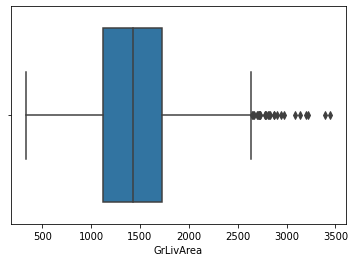

In [371]:
sns.boxplot(train_dataset['GrLivArea'])

In [372]:
iqr_GrLivArea = iqr(train_dataset['GrLivArea']) *1.5
Q75 = train_dataset['GrLivArea'].quantile(0.75)
Q25 = train_dataset['GrLivArea'].quantile(0.25)
print(iqr_GrLivArea)
print(Q25,Q75)

915.375
1117.75 1728.0


In [373]:
train_dataset = train_dataset[train_dataset['GrLivArea']<2615]
# train_dataset = train_dataset[train_dataset['GrLivArea']>239]

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


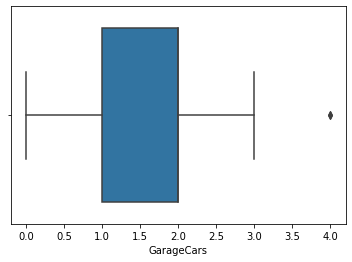

In [374]:
sns.boxplot(train_dataset['GarageCars'])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


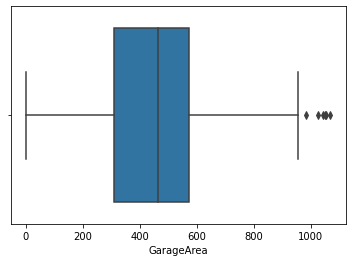

In [375]:
sns.boxplot(train_dataset['GarageArea'])

In [376]:
iqr_GarageArea = iqr(train_dataset['GarageArea']) *1.5
Q75 = train_dataset['GarageArea'].quantile(0.75)
Q25 = train_dataset['GarageArea'].quantile(0.25)
print(iqr_GarageArea)
print(Q25,Q75)

396.0
308.0 572.0


In [377]:
train_dataset = train_dataset[train_dataset['GarageArea']<978]

In [378]:
train_dataset['MSSubClass'] = train_dataset['MSSubClass'].astype(CategoricalDtype([20,30,40,45,50,60,70,75,80,85,90,120,150,160,180,190]))
train_dataset['OverallQual'] = train_dataset['OverallQual'].astype(CategoricalDtype([1,2,3,4,5,6,7,8,9,10]))
train_dataset['OverallCond'] = train_dataset['OverallCond'].astype(CategoricalDtype([1,2,3,4,5,6,7,8,9,10]))

# Encoding catagorical data

In [379]:
train_dataset = pd.concat([train_dataset,pd.get_dummies(train_dataset['MSSubClass'],prefix='MSSubClass',drop_first=True)],axis=1)

In [380]:
train_dataset.drop(['MSSubClass'],axis=1, inplace=True)

In [381]:
train_dataset = pd.concat([train_dataset,pd.get_dummies(train_dataset['OverallQual'],prefix='OverallQual',drop_first=True)],axis=1)

In [382]:
train_dataset.drop(['OverallQual'],axis=1, inplace=True)

In [383]:
train_dataset = pd.concat([train_dataset,pd.get_dummies(train_dataset['OverallCond'],prefix='OverallCond',drop_first=True)],axis=1)

In [384]:
train_dataset.drop(['OverallCond'],axis=1, inplace=True)

In [385]:
print(train_dataset)

        Id  LotArea  LotFrontage  ...  OverallCond_8  OverallCond_9  OverallCond_10
0        1     8450         65.0  ...              0              0               0
1        2     9600         80.0  ...              1              0               0
2        3    11250         68.0  ...              0              0               0
3        4     9550         60.0  ...              0              0               0
4        5    14260         84.0  ...              0              0               0
...    ...      ...          ...  ...            ...            ...             ...
1455  1456     7917         62.0  ...              0              0               0
1456  1457    13175         85.0  ...              0              0               0
1457  1458     9042         66.0  ...              0              1               0
1458  1459     9717         68.0  ...              0              0               0
1459  1460     9937         75.0  ...              0              0         

In [386]:
train_dataset = pd.concat([train_dataset,salePrice],axis=1)

# Training

In [387]:
train_dataset.dropna(inplace=True)

In [388]:
print(train_dataset)

          Id  LotArea  LotFrontage  ...  OverallCond_9  OverallCond_10  SalePrice
0        1.0   8450.0         65.0  ...            0.0             0.0     208500
1        2.0   9600.0         80.0  ...            0.0             0.0     181500
2        3.0  11250.0         68.0  ...            0.0             0.0     223500
3        4.0   9550.0         60.0  ...            0.0             0.0     140000
4        5.0  14260.0         84.0  ...            0.0             0.0     250000
...      ...      ...          ...  ...            ...             ...        ...
1455  1456.0   7917.0         62.0  ...            0.0             0.0     175000
1456  1457.0  13175.0         85.0  ...            0.0             0.0     210000
1457  1458.0   9042.0         66.0  ...            1.0             0.0     266500
1458  1459.0   9717.0         68.0  ...            0.0             0.0     142125
1459  1460.0   9937.0         75.0  ...            0.0             0.0     147500

[1324 rows x 41

In [389]:
print(train_dataset.iloc[:,1:-1])

      LotArea  LotFrontage  ...  OverallCond_9  OverallCond_10
0      8450.0         65.0  ...            0.0             0.0
1      9600.0         80.0  ...            0.0             0.0
2     11250.0         68.0  ...            0.0             0.0
3      9550.0         60.0  ...            0.0             0.0
4     14260.0         84.0  ...            0.0             0.0
...       ...          ...  ...            ...             ...
1455   7917.0         62.0  ...            0.0             0.0
1456  13175.0         85.0  ...            0.0             0.0
1457   9042.0         66.0  ...            1.0             0.0
1458   9717.0         68.0  ...            0.0             0.0
1459   9937.0         75.0  ...            0.0             0.0

[1324 rows x 39 columns]


In [390]:
train_dataset.columns

Index(['Id', 'LotArea', 'LotFrontage', 'TotalBsmtSF', 'GrLivArea',
       'GarageCars', 'GarageArea', 'MSSubClass_30', 'MSSubClass_40',
       'MSSubClass_45', 'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70',
       'MSSubClass_75', 'MSSubClass_80', 'MSSubClass_85', 'MSSubClass_90',
       'MSSubClass_120', 'MSSubClass_150', 'MSSubClass_160', 'MSSubClass_180',
       'MSSubClass_190', 'OverallQual_2', 'OverallQual_3', 'OverallQual_4',
       'OverallQual_5', 'OverallQual_6', 'OverallQual_7', 'OverallQual_8',
       'OverallQual_9', 'OverallQual_10', 'OverallCond_2', 'OverallCond_3',
       'OverallCond_4', 'OverallCond_5', 'OverallCond_6', 'OverallCond_7',
       'OverallCond_8', 'OverallCond_9', 'OverallCond_10', 'SalePrice'],
      dtype='object')

In [391]:
reg = RandomForestRegressor(n_estimators=1000,n_jobs=-1)

In [392]:
reg.fit(train_dataset.iloc[:,1:-1],train_dataset['SalePrice'])

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [393]:
test_dataset = pd.read_csv('/content/drive/My Drive/Datasci/test.csv')

# Encoding catagorical data

In [394]:
test_dataset[col] = test_dataset[col].fillna(0)
test_dataset = test_dataset[col]

In [395]:
test_dataset['MSSubClass'] = test_dataset['MSSubClass'].astype(CategoricalDtype([20,30,40,45,50,60,70,75,80,85,90,120,150,160,180,190]))
test_dataset['OverallQual'] = test_dataset['OverallQual'].astype(CategoricalDtype([1,2,3,4,5,6,7,8,9,10]))
test_dataset['OverallCond'] = test_dataset['OverallCond'].astype(CategoricalDtype([1,2,3,4,5,6,7,8,9,10]))

In [396]:
print(test_dataset[col].isna().sum())

Id             0
MSSubClass     0
LotArea        0
LotFrontage    0
OverallQual    0
OverallCond    0
TotalBsmtSF    0
GrLivArea      0
GarageCars     0
GarageArea     0
dtype: int64


In [397]:
test_dataset = pd.concat([test_dataset,pd.get_dummies(test_dataset['MSSubClass'],prefix='MSSubClass',drop_first=True)],axis=1)
test_dataset.drop(['MSSubClass'],axis=1, inplace=True)
test_dataset = pd.concat([test_dataset,pd.get_dummies(test_dataset['OverallQual'],prefix='OverallQual',drop_first=True)],axis=1)
test_dataset.drop(['OverallQual'],axis=1, inplace=True)
test_dataset = pd.concat([test_dataset,pd.get_dummies(test_dataset['OverallCond'],prefix='OverallCond',drop_first=True)],axis=1)
test_dataset.drop(['OverallCond'],axis=1, inplace=True)

In [398]:
print(test_dataset.iloc[:,1:])

      LotArea  LotFrontage  ...  OverallCond_9  OverallCond_10
0       11622         80.0  ...              0               0
1       14267         81.0  ...              0               0
2       13830         74.0  ...              0               0
3        9978         78.0  ...              0               0
4        5005         43.0  ...              0               0
...       ...          ...  ...            ...             ...
1454     1936         21.0  ...              0               0
1455     1894         21.0  ...              0               0
1456    20000        160.0  ...              0               0
1457    10441         62.0  ...              0               0
1458     9627         74.0  ...              0               0

[1459 rows x 39 columns]


In [399]:
test_dataset.columns

Index(['Id', 'LotArea', 'LotFrontage', 'TotalBsmtSF', 'GrLivArea',
       'GarageCars', 'GarageArea', 'MSSubClass_30', 'MSSubClass_40',
       'MSSubClass_45', 'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70',
       'MSSubClass_75', 'MSSubClass_80', 'MSSubClass_85', 'MSSubClass_90',
       'MSSubClass_120', 'MSSubClass_150', 'MSSubClass_160', 'MSSubClass_180',
       'MSSubClass_190', 'OverallQual_2', 'OverallQual_3', 'OverallQual_4',
       'OverallQual_5', 'OverallQual_6', 'OverallQual_7', 'OverallQual_8',
       'OverallQual_9', 'OverallQual_10', 'OverallCond_2', 'OverallCond_3',
       'OverallCond_4', 'OverallCond_5', 'OverallCond_6', 'OverallCond_7',
       'OverallCond_8', 'OverallCond_9', 'OverallCond_10'],
      dtype='object')

In [400]:
result = reg.predict(test_dataset.iloc[:,1:])

In [401]:
print(result)

[133326.151 158546.692 160081.117 ... 168318.434 104021.001 235692.856]


In [402]:
ans=pd.DataFrame({'SalePrice':result})
submission = pd.concat([test_dataset['Id'],ans],axis=1)
submission.to_csv('/content/drive/My Drive/Datasci/outputrandom_forest10.csv', index=False)